This Custom NER pipeline with Spacy 3.0 extracts and trains annotated data and detects NER.
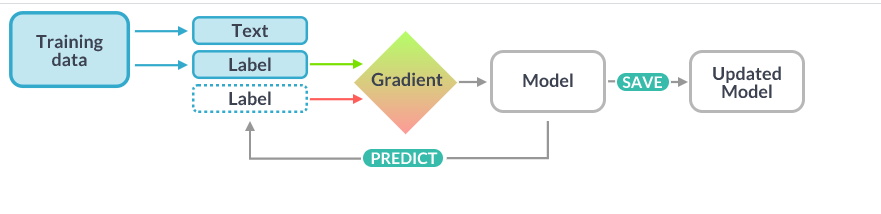


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. training upload - convert all train files to spacy.md -- done
2. train the data on pretrained, blank and merged -- done
3. merge two classifiers (for blank and pretrained) for catastrophic forgetting-- done 
4. evaluation -- done, but add more verbose interpretation/comments
5. lit review -- doing
6. steps full in paper -- doing (google doc) -merge


1. Download required packages, libraries

In [ ]:
#Download packages
!pip install -U spacy==3.1.0 #newest spacy version
!python3 -m spacy download en
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download en_core_web_lg
!python3 -m spacy download en_core_web_md

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.6 MB 23.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0-py3-none-any.whl (13.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 777.1 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
     |████████████████████████████████| 45.4 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
#Optionally show spacy info
!python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.1.0                         
Location         /usr/local/lib/python3.7/dist-packages/spacy
Platform         Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
Python version   3.7.12                        
Pipelines        en_core_web_lg (3.1.0), en_core_web_md (3.1.0), en_core_web_sm (3.1.0)



In [ ]:
#Import libraries
import json 
import glob
import spacy
import random
import en_core_web_sm
from spacy import displacy #visualize output
from pathlib import Path


2. Load all training files from the source folder

In [ ]:
source_path='/content/drive/MyDrive/Bushire-GT-compound/training_data_json/'
source_path_duplicates='/content/drive/MyDrive/Bushire-GT-compound/training_data_json_duplicates/'
non_empty=False
for f in glob.glob(source_path+"*.json"):
  with open(f) as infile:
    non_empty=True
    #print(f)
if non_empty:
  print("non-empty")
else:
  print("empty")


non-empty


In [ ]:
#Define the source folder
source_path='/content/drive/MyDrive/Bushire-GT-compound/training_data_json/'
source_path_duplicates='/content/drive/MyDrive/Bushire-GT-compound/training_data_json_duplicates/'

def load_json_files(path,train_files_,train_annotations_):
  for f in glob.glob(path+"*.json"):
      with open(f) as infile:
          name=infile.name.split("/")[-1]
          index=name.find(".json")
          name=name[:index]
          train_files_[name]=json.load(infile)
          #Store annotation section of each json file in a separate array
          #if 'annotations' in train_files[name]:
          train_annotations_[name]=train_files_[name]['annotations']  
      
    
      

#Load all json files from the source folder and append them to the dictionary 
train_files = {} #-- name stores file name and value stores full json content
train_annotations={} #-- name stores file name and value stores json content - only annotation section
#load train files, non-duplicates
load_json_files(source_path,train_files, train_annotations)

train_files_dup={}
train_annotations_dup={}
load_json_files(source_path_duplicates,train_files_dup, train_annotations_dup)

In [ ]:
#Note: additional preprocessing was done remotely to clean the labels (i.e. MONAY->MONEY and PERSON_->PERSON)
labels=set()
for name in train_files:
    train_data=train_files[name]
    for i in range(len(train_data["classes"])):
      label=train_data["classes"][i]
      labels.add(label)
print(labels)

{' LOC', 'GPE', 'COMMODITY', 'TITLE', 'UNKNOWN', 'MONEY', 'VESSEL', 'REL', 'QUANTITY', 'LOC', 'TRIBE', 'DATE', 'REL ', 'GPE_ORG', 'ORG', 'NORP', 'STRUCTURE', 'PERSON'}


In [ ]:
train_files

In [ ]:
train_annotations

{}

3. Convert json data to spacy format -- required for training in Spacy 3.0; in Spacy 2.0 - this step allows to train multiple files

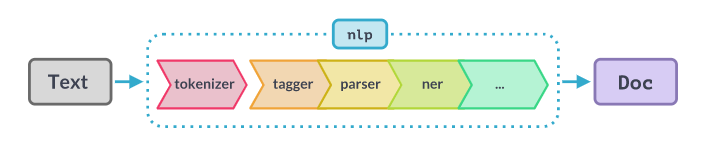



3. A. Train blank model

In [ ]:
from spacy.training import Example
from spacy.tokens import DocBin
from tqdm import tqdm

def convert_to_spacy_blank(output_path_,train_files_,nlp):  
  for name in train_files:
      current_file=train_files_[name]
      #new name of the file - append to output path
      new_name=output_path_+name+".spacy" 
      #create docbin project
      db = DocBin()
      for text, annotations in tqdm(current_file['annotations']):
        doc = nlp.make_doc(text) 
        ents = []
        for start, end, label in annotations["entities"]:
          span = doc.char_span(start, end, label=label, alignment_mode="contract")
          if span is None:
              print("We skip the entity")
          else:
              ents.append(span)
        doc.ents = ents 
        db.add(doc)
      #Save the docbin file to the drive
      db.to_disk(new_name)
output_path='/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/'
output_path_dup='/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/'
nlp = spacy.blank("en")
convert_to_spacy_blank(output_path,train_files,nlp)
nlp_dup = spacy.blank("en")
convert_to_spacy_blank(output_path_dup,train_files_dup,nlp_dup)
    

100%|██████████| 10/10 [00:00<00:00, 539.64it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 4/4 [00:00<00:00, 206.54it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 458.28it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 46.55it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 2/2 [00:00<00:00, 81.40it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 396.84it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 4/4 [00:00<00:00, 183.21it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 437.42it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 45.18it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 2/2 [00:00<00:00, 274.99it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 61/61 [00:00<00:00, 1369.66it/s]


In [ ]:
#Debugging -- misalignment in annotated data - future improvement section
'''
for text, annotations in train_files['xaa-s']['annotations']:
    example = Example.from_dict(nlp.make_doc(text), annotations)
    db.add(example.reference)

db.to_disk("td2.spacy")
'''
'''
entities=train_files['xaa-s']['annotations'][0][1]['entities']
entities
spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)
'''

"\nentities=train_files['xaa-s']['annotations'][0][1]['entities']\nentities\nspacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)\n"

3. B. Pretrained model

In [ ]:
from spacy.training import Example
from spacy.tokens import DocBin
from tqdm import tqdm
import random
from spacy import util
from spacy.tokens import Doc
from spacy.language import Language

def add_labels(train_files_,nlp_pretrained,labels):
  for name in train_files_:
    train_data=train_files_[name]
    for i in range(len(train_data["classes"])):
      label=train_data["classes"][i]
      label=label.strip()
      train_files_[name]["classes"][i]=label
      labels.add(label)

  ner_pretrained=nlp_pretrained.get_pipe('ner')
  existing_labels=ner_pretrained.labels
  
  for label in labels:
    label=label.strip()
    if label not in existing_labels:
      ner_pretrained.add_label(label)

def update_labels(train_files_,nlp_pretrained):
  for name in train_files_:
      train_data=train_files_[name]
      train_data=train_files_[name]['annotations']
      #create docbin project
      db = DocBin()
      # Disable all pipe components except 'ner'
      disabled_pipes = []
      for pipe_name in nlp_pretrained.pipe_names:
          if pipe_name != 'ner':
              nlp_pretrained.disable_pipes(pipe_name)
              disabled_pipes.append(pipe_name)
      optimizer = nlp_pretrained.create_optimizer()
      for _ in range(25):
          random.shuffle(train_data)
          for raw_text, entity_offsets in train_data:
              if len(raw_text) > 0:
                doc = nlp_pretrained.make_doc(raw_text)
                example = Example.from_dict(doc, {"entities": entity_offsets['entities']})
                nlp_pretrained.update([example], sgd=optimizer)

      # Enable all previously disabled pipe components
      for pipe_name in disabled_pipes:
          nlp_pretrained.enable_pipe(pipe_name)
      '''
      # Result after training
      print(f"Result AFTER training:")
      doc = nlp(u'I need a taxi to Festy.')
      print_doc_entities(doc)
      '''
def convert_to_spacy_pretrained(output_path_,train_files_,nlp_pretrained):
  

  #Load pretrained model loaded from spacy
  for name in train_files_:
      current_file=train_files_[name]
      #new name of the file - append to output path
      new_name=output_path_+name+".spacy" 
      #create docbin project
      db = DocBin()
      for text, annotations in tqdm(current_file['annotations']):
        doc = nlp_pretrained.make_doc(text) 
        ents = []
        for start, end, label in annotations["entities"]:
          span = doc.char_span(start, end, label=label, alignment_mode="contract")
          if span is None:
              print("We skip the entity")
          else:
              ents.append(span)
        doc.ents = ents 
        db.add(doc)
      #Save the docbin file to the drive
      db.to_disk(new_name)
labels=set()
output_path='/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/'
output_path_dup='/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/'
nlp_pretrained = en_core_web_sm.load()
add_labels(train_files,nlp_pretrained,labels)
update_labels(train_files,nlp_pretrained)
convert_to_spacy_pretrained(output_path,train_files,nlp_pretrained)
convert_to_spacy_pretrained(output_path_dup,train_files_dup,nlp_pretrained)

/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "there Parts for of the Baniattaba Arabs_ By land t..." with entities "[[24, 41, 'TRIBE']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "originated in packing the Bales at Europe or in Sh..." with entities "[[35, 41, 'GPE'], [66, 73, 'GPE']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: Use

We skip the entity
We skip the entity
We skip the entity


100%|██████████| 4/4 [00:00<00:00, 637.43it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 646.56it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 96.79it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 2/2 [00:00<00:00, 356.20it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 791.32it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 830.92it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 522.89it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 782.84it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 1011.89it/s]


We skip the entity
We skip the entity
We skip the entity


100%|██████████| 10/10 [00:00<00:00, 800.13it/s]

We skip the entity
We skip the entity
We skip the entity



100%|██████████| 4/4 [00:00<00:00, 624.50it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 4/4 [00:00<00:00, 417.12it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 4/4 [00:00<00:00, 305.84it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 4/4 [00:00<00:00, 449.36it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 4/4 [00:00<00:00, 407.97it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 4/4 [00:00<00:00, 427.49it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 821.23it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 812.31it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 606.27it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



  0%|          | 0/12 [00:00<?, ?it/s]

We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 551.91it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 783.63it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 12/12 [00:00<00:00, 766.88it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 1/1 [00:00<00:00, 80.40it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 67.54it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 76.62it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 88.04it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 1/1 [00:00<00:00, 80.11it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 1/1 [00:00<00:00, 96.12it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 2/2 [00:00<00:00, 190.35it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 2/2 [00:00<00:00, 161.74it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 2/2 [00:00<00:00, 184.24it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity



100%|██████████| 2/2 [00:00<00:00, 262.64it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 2/2 [00:00<00:00, 401.85it/s]


We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


  0%|          | 0/2 [00:00<?, ?it/s]

We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity
We skip the entity


100%|██████████| 61/61 [00:00<00:00, 1392.21it/s]


In [ ]:
ner_pretrained=nlp_pretrained.get_pipe('ner')
for name in ner_pretrained.labels[::-1]: 
  print(name)

WORK_OF_ART
VESSEL
UNKNOWN
TRIBE
TITLE
TIME
STRUCTURE
REL
QUANTITY
PRODUCT
PERSON
PERCENT
ORG
ORDINAL
NORP
MONEY
LOC
LAW
LANGUAGE
GPE_ORG
GPE
FAC
EVENT
DATE
COMMODITY
CARDINAL


4. Create the config file for training the model.

The config file can be downloaded from this [link](https://spacy.io/usage/training#config)

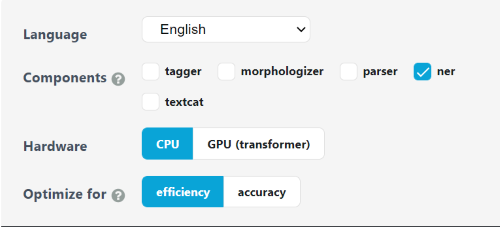

5. Run the training cnfg file



5. A. Blank model

In [ ]:
#! python -m spacy init fill-config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/base_config.cfg /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
! python -m spacy init config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/config.cfg --force --lang en --pipeline ner --optimize efficiency


⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
#! python -m spacy init fill-config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/base_config.cfg /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
! python -m spacy init config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/config.cfg --force --lang en --pipeline ner --optimize efficiency


⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


5. B. Pretrained model

In [ ]:
#! python -m spacy init fill-config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/base_config.cfg /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
! python -m spacy init config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/config.cfg --force --lang en --pipeline ner --optimize efficiency


⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
#! python -m spacy init fill-config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/base_config.cfg /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
! python -m spacy init config /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/config.cfg --force --lang en --pipeline ner --optimize efficiency


⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


6. Run the training configuration -- todo - interpretation

6. A. Blank model

In [ ]:
#!python -m spacy train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/config.cfg --output /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/output --paths.train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/ --paths.dev /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/ 


ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-02-13 06:44:18,920] [INFO] Set up nlp object from config
[2022-02-13 06:44:18,933] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-02-13 06:44:18,939] [INFO] Created vocabulary
[2022-02-13 06:44:18,940] [INFO] Finished initializing nlp object
[2022-02-13 06:44:20,787] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.48    0.00    0.00    0.00    0.00
  2     200       6539.85   4791.92   53.85   54.84   52.89    0.54
  4     400       2599.71   3428.24   65.90   63.00   69.09    0.66
  7     600       1513.62   3259.08   75.33   71.18   80.00    0.75
 10     800 

In [ ]:
#!python -m spacy train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/config.cfg --output /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/output --paths.train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/ --paths.dev /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/ 


ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-02-12 06:06:18,910] [INFO] Set up nlp object from config
[2022-02-12 06:06:18,923] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-02-12 06:06:18,928] [INFO] Created vocabulary
[2022-02-12 06:06:18,929] [INFO] Finished initializing nlp object
[2022-02-12 06:06:21,426] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.48    0.00    0.00    0.00    0.00
  2     200       6539.85   4791.92   53.85   54.84   52.89    0.54
  4     400       2599.71   3428.24   65.90   63.00   69.09    0.66
  7     600       1513.62   3259.08   75.33   71.18   80.00    0.75
 10     800 

6. B. Pretrained model

In [ ]:
#!python -m spacy train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/config.cfg --output /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/output --paths.train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/ --paths.dev /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/ 


ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-02-13 08:39:03,826] [INFO] Set up nlp object from config
[2022-02-13 08:39:03,841] [INFO] Pipeline: ['ner']
[2022-02-13 08:39:03,853] [INFO] Copying tokenizer from: en_core_web_sm
[2022-02-13 08:39:04,524] [INFO] Copying vocab from: en_core_web_sm
[2022-02-13 08:39:04,704] [INFO] Created vocabulary
[2022-02-13 08:39:04,706] [INFO] Finished initializing nlp object
[2022-02-13 08:39:06,036] [INFO] Initialized pipeline components: ['ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['ner']
ℹ Frozen components: ['tok2vec', 'tagger', 'parser', 'senter',
'attribute_ruler', 'lemmatizer']
ℹ Initial learn rate: 0.001
E    #       LOSS NER  TAG_ACC  DEP_UAS  DEP_LAS  SENTS_P  SENTS_R  SENTS_F  LEMMA_ACC  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  --------  -------  -------  -------  -------  -------  -------  ---------  ------  --

In [ ]:
#!python -m spacy train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/config.cfg --output /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/output --paths.train /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/ --paths.dev /content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/ 


ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-02-13 09:01:01,102] [INFO] Set up nlp object from config
[2022-02-13 09:01:01,117] [INFO] Pipeline: ['ner']
[2022-02-13 09:01:01,129] [INFO] Copying tokenizer from: en_core_web_sm
[2022-02-13 09:01:01,799] [INFO] Copying vocab from: en_core_web_sm
[2022-02-13 09:01:01,985] [INFO] Created vocabulary
[2022-02-13 09:01:01,986] [INFO] Finished initializing nlp object
[2022-02-13 09:01:07,990] [INFO] Initialized pipeline components: ['ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['ner']
ℹ Frozen components: ['tok2vec', 'tagger', 'parser', 'senter',
'attribute_ruler', 'lemmatizer']
ℹ Initial learn rate: 0.001
E    #       LOSS NER  TAG_ACC  DEP_UAS  DEP_LAS  SENTS_P  SENTS_R  SENTS_F  LEMMA_ACC  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  --------  -------  -------  -------  -------  -------  -------  ---------  ------  --

7. Load the best model for blank, pretrained pipelines

7. A. Blank model

In [ ]:
nlp_ner_blank = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank/output/model-best")
nlp_ner_blank_dup = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/blank_dup/output/model-best")


OSError: ignored

In [ ]:
print("Pipeline objects: %s" % nlp_ner_blank.pipe_names)

Pipeline objects: ['tok2vec', 'ner']


7. B. Pretrained model

In [ ]:
nlp_ner_pretrained = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained/output/model-best")
nlp_ner_pretrained_dup = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/spacy_training_output/pretrained_dup/output/model-best")

In [ ]:
print("Pipeline objects: %s" % nlp_ner_pretrained.pipe_names)

Pipeline objects: ['ner']


8. Merge custom trained blank and pretrained models with the default 'en_core_web_md' model.

Here we are loading BOTH custom trained and existing models together! Solves the catastrophic forgetting problem. More info [here](https://github.com/explosion/spaCy/discussions/9940)

In [ ]:
# Load the pretrained scispacy model 
pure_nlp_default=spacy.load("en_core_web_lg")
pure_nlp_default_sm=spacy.load("en_core_web_sm")
merged_nlp_blank = spacy.load("en_core_web_sm")
merged_nlp_pretrained = spacy.load("en_core_web_sm")
merged_nlp_blank_dup = spacy.load("en_core_web_sm")
merged_nlp_pretrained_dup = spacy.load("en_core_web_sm")

# Load the blank custom NER model and give this component a copy of its own tok2vec
nlp_ner_blank.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
nlp_ner_blank_dup.replace_listeners("tok2vec", "ner", ["model.tok2vec"])

# Load the pretrained custom NER model and give this component a copy of its own tok2vec
#nlp_ner_pretrained.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
#nlp_ner_pretrained_dup.replace_listeners("tok2vec", "ner", ["model.tok2vec"])


OSError: ignored

In [ ]:
#Merge custom blank model with the new pretrained model 'en_core_web_md'
#we put the blank ner component before or after the other ner
merged_nlp_blank.add_pipe(
    "ner",
    name="ner_blank",
    source=nlp_ner_blank,
    before="ner",
)
merged_nlp_blank_dup.add_pipe(
    "ner",
    name="ner_blank_dup",
    source=nlp_ner_blank_dup,
    before="ner",
)


#Merge custom pretrained model with the new pretrained model 'en_core_web_md'
merged_nlp_pretrained.add_pipe(
    "ner",
    name="ner_pretrained",
    source=nlp_ner_pretrained,
    before="ner",
)
merged_nlp_pretrained_dup.add_pipe(
    "ner",
    name="ner_pretrained_dup",
    source=nlp_ner_pretrained_dup,
    before="ner",
)


#Print components of the merged blank model
print(merged_nlp_blank.pipe_names)

#Print components of the merged pretrained model
print(merged_nlp_pretrained.pipe_names)


NameError: ignored

In [ ]:
#Save all models to the disk
model_dir='/content/drive/MyDrive/Bushire-GT-compound/saved_models'
model_dir = Path(model_dir)
if not model_dir.exists():
    model_dir.mkdir()

#Give names to the models
nlp_ner_blank.meta['name']="blank_new_model"
#nlp_ner_pretrained.meta['name'] = "pretrained_new_model"  # rename model
merged_nlp_blank.meta['name'] = "merged_blank_model"  # rename model
merged_nlp_pretrained.meta['name'] = "merged_pretrained_model"  # rename model

#Give names to the models
nlp_ner_blank_dup.meta['name']="blank_new_model_dup"
#nlp_ner_pretrained.meta['name'] = "pretrained_new_model"  # rename model
merged_nlp_blank_dup.meta['name'] = "merged_blank_model_dup"  # rename model
merged_nlp_pretrained_dup.meta['name'] = "merged_pretrained_model_dup"  # rename model

#Save updated models to the disk
nlp_ner_blank.to_disk(model_dir)
nlp_ner_pretrained.to_disk(model_dir)
merged_nlp_blank.to_disk(model_dir)
merged_nlp_pretrained.to_disk(model_dir)

nlp_ner_blank_dup.to_disk(model_dir)
nlp_ner_pretrained_dup.to_disk(model_dir)
merged_nlp_blank_dup.to_disk(model_dir)
merged_nlp_pretrained_dup.to_disk(model_dir)

print("Saved model to", model_dir)

Saved model to /content/drive/MyDrive/Bushire-GT-compound/saved_models


9. Print entities

9. A. Blank model

In [ ]:
# Updated entity labels for the pretrained model
ner_blank=nlp_ner_blank.get_pipe("ner")
print('[Blank model: entity labels]')
for name in ner_blank.labels:
  print(name)

[Blank model: entity labels]
COMMODITY
DATE
GPE
GPE_ORG
LOC
MONEY
NORP
ORG
PERSON
QUANTITY
REL
STRUCTURE
TITLE
TRIBE
UNKNOWN
VESSEL


9. B. Pretrained model

In [ ]:
# Updated entity labels for the pretrained model
ner_pretrained=nlp_ner_pretrained.get_pipe("ner")
print('[Pretrained model: entity labels]')
for name in ner_pretrained.labels:
  print(name)

[Pretrained model: entity labels]
COMMODITY
DATE
GPE
GPE_ORG
LOC
MONEY
NORP
ORG
PERSON
QUANTITY
REL
STRUCTURE
TITLE
TRIBE
UNKNOWN
VESSEL


9. C. Merged model (blank + default)

In [ ]:
# Updated entity labels for the merged model (blank + default)
ner_pretrained=merged_nlp_pretrained.get_pipe("ner_pretrained")
print('[Pretrained model: entity labels]')
for name in ner_pretrained.labels:
  print(name)

[Pretrained model: entity labels]
COMMODITY
DATE
GPE
GPE_ORG
LOC
MONEY
NORP
ORG
PERSON
QUANTITY
REL
STRUCTURE
TITLE
TRIBE
UNKNOWN
VESSEL


10. Load the test datasets

In [ ]:
#Test dataset 1
try:
  test_txt1 = open("/content/drive/MyDrive/Bushire-GT-compound/inputs/1825OCR_page15.txt",encoding='windows-1252')
  text1=test_txt1.read()
except UnicodeDecodeError:
  test_txt1 = open("/content/drive/MyDrive/Bushire-GT-compound/inputs/1825OCR_page15.txt",encoding="utf8")
  text1=test_txt1.read()
text1=text1.replace("\n", " ")

#Test dataset 2
try:
  test_txt2 = open("/content/drive/MyDrive/Bushire-GT-compound/iraq.txt",encoding="windows-1252")
  text2=test_txt2.read()
except UnicodeDecodeError:
  test_txt2 = open("/content/drive/MyDrive/Bushire-GT-compound/iraq.txt",encoding="utf8")
  text2=test_txt2.read()

text2=text2.replace("\n", " ")
text2=text2.replace("\'", " ")

In [ ]:
text1

'!• * f* ? * Statement of slave Faraj bin Yusof a^ed about 30 years recorded in the Political Agency ,Bahrain. I was born in kadinahvHijaz). ^y parents were slaves of one Thuwaibi. when I was very young about five years old my mother and myself were taken to Doha(Qatar)and sold there to { Bin Mana\'. We both remained in his service for a short time. 1 Afterwards one lesa bin Ali Al-Khater of Jubaii came to Doha and I was sold to him by my former master. I used to go for diving and earn for my last master but he was not giving me anything out of xiy earnings. During f the winter time I used to accompany my master to the desert of Jubaii for shooting gazelles and uirdo. liy master was not providing me with adequate food and clothing. He occasionally used to beat me without any reason. Finding it impossible for me to serve my master any longer owing to tne above facts,I managed to escape from him and came to Bahrain. I request the High Government to grant me a manumission \\ ¦ | certifica

In [ ]:
len(text1)

1424

In [ ]:
text2

' IRĀQ (TURKISH) (46173 words) [title note] 1  العراق  [return to Geographical Dictionary terms]  The ancient name  Iraq2 —of which the etymology, or at least the meaning in the present case, is doubtful3 —is used by the Ottomah Grovernment to denote the country of the lower Euphrates and Tigris—the richest and most valuable in the whole basin of the Persian Gulf—which is comprised in the Turkish Wilāyats or provinces of Baghdād and Basrah. In British official terminology Turkish  Irāq, with the addition of the more northern Wilāyat of Mūsal موصل, is conventionally known as "Turkish Arabia"; but the expression is an unfortunate one, for it obviously suggests the Red Sea provinces of Yaman and Hijāz rather than Mesopotamia which is no part, either physically or politically, of the Arabian peninsula. In the vernacular, Turkish  Irāq is known as  Irāq-al-  Arabi in contradistinction to  Irāq-al-  It remains to mention a few of the principal books, etc., which may be consulted, in regard t

In [ ]:
len(text2)


10. Detect Named Entities

10.0. Detect NE from all models and save html output

In [ ]:
import os
#dictionary that maps existing models and names
model_dict={"pure":pure_nlp_default,"pure-sm":pure_nlp_default_sm,"blank":nlp_ner_blank,"pretrained":nlp_ner_pretrained,"merged-blank":merged_nlp_blank,"merged-pretrained":merged_nlp_pretrained,"blank_dup":nlp_ner_blank_dup,"pretrained_dup":nlp_ner_pretrained_dup,"merged-blank_dup":merged_nlp_blank_dup,"merged-pretrained_dup":merged_nlp_pretrained_dup}
#directory paths to store text inputs and output 
input_path='/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_inputs/'
output_path="/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_outputs/"
#store file name and file content in a dictionary
input_texts={}
#read every file in the input directory

for f in glob.glob("/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_inputs/*.txt"):
      try:
        infile=open(f,encoding='utf8')
        #read file
        text=infile.read()
      except UnicodeDecodeError:
        infile=open(f,encoding='windows-1252')
        #read file
        text=infile.read()
      #extract name of the file
      name=infile.name.split("/")[-1]
      index=name.find(".txt")
      name=name[:index]
      text=text.replace("\n", " ")
      text=text.replace("\'", " ")
      #create directory for the file if it doesnt exist
      directory=output_path+name+"/"
      if not os.path.exists(directory):
        os.makedirs(directory)
      #store text and its associated file name
      input_texts[name]=text
      #go through each model and store the displacy output
      for model_name,model in model_dict.items():
        #create doc_object and recognize named entities
        doc_object=model(text)
        #write down entities in the doc_object
        for ent in doc_object.ents:
          path=directory+model_name+".txt"
          f = open((path), "w")
          for ent in doc_object.ents:
            f.write(ent.text+" "+ent.label_)
            f.write("\n")
          f.close()
        #visualize displacy output and store in html file
        html =  displacy.render(doc_object, style='ent', page=True)
        file_path=directory+model_name+".html"
        #write html file to the output directory
        with open(file_path, 'w+', encoding="utf-8") as fp:
          fp.write(html)
          fp.close()
      

In [ ]:
input_texts

{'1825OCR_page15': '!• * f* ? * Statement of slave Faraj bin Yusof a^ed about 30 years recorded in the Political Agency ,Bahrain. I was born in kadinahvHijaz). ^y parents were slaves of one Thuwaibi. when I was very young about five years old my mother and myself were taken to Doha(Qatar)and sold there to { Bin Mana . We both remained in his service for a short time. 1 Afterwards one lesa bin Ali Al-Khater of Jubaii came to Doha and I was sold to him by my former master. I used to go for diving and earn for my last master but he was not giving me anything out of xiy earnings. During f the winter time I used to accompany my master to the desert of Jubaii for shooting gazelles and uirdo. liy master was not providing me with adequate food and clothing. He occasionally used to beat me without any reason. Finding it impossible for me to serve my master any longer owing to tne above facts,I managed to escape from him and came to Bahrain. I request the High Government to grant me a manumissio

10. A. Blank model

Test file 1

In [ ]:
doc_blank1 = nlp_ner_blank(text1)
for ent in doc_blank1.ents:
  print(ent)

30 years
Agency
five years
{ Bin Mana'. We both
,Bahrain
Slave Trade. Correspondence
' 686


In [ ]:
for ent in doc_blank1.ents:
    print(ent.text,ent.label_)
    print()

30 years QUANTITY

Agency ORG

five years QUANTITY

{ Bin Mana'. We both PERSON

,Bahrain PERSON

Slave Trade. Correspondence PERSON

' 686 GPE



todo-- manual f-score
and compare default and custom entity recognition

In [ ]:
displacy.render(doc_blank1, style="ent", jupyter=True)

Test file 2

In [ ]:
doc_blank2 = nlp_ner_blank(text2)
for ent in doc_blank2.ents:
  print(ent)

Ottomah Grovernment
lower Euphrates and Tigris—the
Persian Gulf—which
Turkish Wilāyats
Baghdād
Basrah.
Turkish  Irāq
Wilāyat of Mūsal
Turkish
Red
Arabian
Ainsworth
Rivers Euphrates and
,
;
,
;
,
;
,
;
the
; and
of
, 1889
s La
.
that
for the Baghdād
that
for the Basrah
1904, by Captain
of the Government
fur
is Mr.
is Colonel F.
of the
of trade. Mr. G.
s
during the
of the
of the
of India for
of the German
Rivers Euphrates and
,
Tureopersian Frontier made by
Russian mission
Selby
Collingwood
Bewsher
Baghdād
India
Persia
India
,
Persian Gulf,
Admiralty Chart No. 2380-1235
Euphrates
Admiralty Chart No. 2381-3293
Kuweit Harbour
Shatt-al-Arab
1904; finally a Sketch
India
Shatt-al-
Arab
Basrah
Asia
Persian Gulf Sheet
Persia
Basrah.
Baghdād
Basrah Wilāyats
— Irāq
Shāmlyah Desert
Kuwait Principality
Persian Gulf.
Persian border
Kādhimain
Porte
Shāmīyah Desert
Wilāyats of Baghdād and Basrah
Euphrates valley
Shifāthah
Najaf Town
Rahabah
Zubair Town
Kuwait Principality
British Government
Safwān
Umm

In [ ]:
for ent in doc_blank2.ents:
    print(ent.text,ent.label_)
    print()

Ottomah Grovernment ORG

lower Euphrates and Tigris—the LOC

Persian Gulf—which LOC

Turkish Wilāyats GPE

Baghdād GPE

Basrah. GPE

Turkish  Irāq GPE

Wilāyat of Mūsal GPE

Turkish GPE

Red LOC

Arabian LOC

Ainsworth PERSON

Rivers Euphrates and LOC

, DATE

; PERSON

, DATE

; PERSON

, DATE

; GPE

, DATE

; PERSON

the LOC

; and PERSON

of GPE

, 1889 PERSON

s La GPE

. DATE

that DATE

for the Baghdād GPE

that DATE

for the Basrah GPE

1904, by Captain PERSON

of the Government ORG

fur DATE

is Mr. PERSON

is Colonel F. PERSON

of the ORG

of trade. Mr. G. PERSON

s GPE

during the ORG

of the ORG

of the ORG

of India for DATE

of the German ORG

Rivers Euphrates and LOC

, DATE

Tureopersian Frontier made by NORP

Russian mission LOC

Selby NORP

Collingwood NORP

Bewsher GPE

Baghdād GPE

India GPE

Persia GPE

India GPE

, DATE

Persian Gulf, LOC

Admiralty Chart No. 2380-1235 PERSON

Euphrates LOC

Admiralty Chart No. 2381-3293 PERSON

Kuweit Harbour PERSON

Shatt-al-Ara

In [ ]:
displacy.render(doc_blank2, style="ent", jupyter=True)

10. B. Pretrained model

Test file 1

In [ ]:
doc_pretrained1 = nlp_ner_pretrained(text1)
for ent in doc_pretrained1.ents:
  print(ent)


30 years
Agency
Bahrain
five years
Khater
Bahrain
'File
'


In [ ]:
for ent in doc_pretrained1.ents:
    print(ent.text,ent.label_)
    print()

30 years QUANTITY

Agency ORG

Bahrain GPE

five years QUANTITY

Khater PERSON

Bahrain GPE

'File GPE

' GPE



In [ ]:
displacy.render(doc_pretrained1, style="ent", jupyter=True)

Test file 2

In [ ]:
doc_pretrained2 = nlp_ner_pretrained(text2)
for ent in doc_pretrained2.ents:
  print(ent)

Ottomah Grovernment
lower Euphrates and Tigris—the
Persian Gulf—which
Turkish Wilāyats
Baghdād
Basrah.
Turkish  Irāq
Wilāyat of Mūsal
Turkish
Red
Arabian
Ainsworth
Rivers Euphrates and
,
;
,
;
,
;
,
;
the
; and
of
, 1889
.
that
for the Baghdād
that
for the Basrah
1904, by Captain
of the Government
fur
is Mr.
is Colonel F.
of the
of trade. Mr. G.
during the
of the
of the
of India for
of the German
Rivers Euphrates and
,
; Sheets
British
Russian
Bewsher
Baghdād
India
Map
Persia
India
Persian Gulf, published
Admiralty Chart
Euphrates
1903
Admiralty Chart
Shatt-al-Arab
India
Captain Bowden
Shatt-al-
Arab
Basrah
1906
Persian Gulf Sheet
Persia
Baghdād
Wilāyat of Basrah
Basrah Wilāyats
Najd
Qasīm.
Shāmlyah Desert
Kuwait Principality
Persian Gulf.
Persian border
Kādhimain
Porte
Shāmīyah Desert
Wilāyats of Baghdād and Basrah
Euphrates valley
Shifāthah
Najaf Town
Rahabah
Zubair Town
Kuwait Principality
British Government
Safwān
Umm Qasr
His Majesty
Porte
Būbiyān island
Persian Gulf and Kārūn riv

In [ ]:
for ent in doc_pretrained2.ents:
    print(ent.text,ent.label_)
    print()

Streaming output truncated to the last 5000 lines.
of GPE

, 1889 PERSON

. DATE

that DATE

for the Baghdād GPE

that DATE

for the Basrah GPE

1904, by Captain PERSON

of the Government ORG

fur DATE

is Mr. PERSON

is Colonel F. PERSON

of the ORG

of trade. Mr. G. PERSON

during the ORG

of the ORG

of the ORG

of India for DATE

of the German ORG

Rivers Euphrates and LOC

, DATE

; Sheets PERSON

British STRUCTURE

Russian ORG

Bewsher GPE

Baghdād GPE

India GPE

Map GPE_ORG

Persia GPE

India GPE

Persian Gulf, published GPE

Admiralty Chart TITLE

Euphrates LOC

1903 NORP

Admiralty Chart TITLE

Shatt-al-Arab LOC

India GPE

Captain Bowden VESSEL

Shatt-al- LOC

Arab NORP

Basrah GPE

1906 DATE

Persian Gulf Sheet GPE

Persia GPE

Baghdād GPE

Wilāyat of Basrah GPE

Basrah Wilāyats GPE

Najd PERSON

Qasīm. COMMODITY

Shāmlyah Desert LOC

Kuwait Principality GPE

Persian Gulf. LOC

Persian border LOC

Kādhimain GPE

Porte ORG

Shāmīyah Desert LOC

Wilāyats of Baghdād and Basrah

In [ ]:
displacy.render(doc_pretrained2, style="ent", jupyter=True)

10. C. Merged model (blank + default)

Test file 1

In [ ]:
doc_merged_blank1 = merged_nlp_blank(text1)
for ent in doc_merged_blank1.ents:
  print(ent)


Faraj bin Yusof
30 years
the Political
Agency
Bahrain
kadinahvHijaz
one
five years
{ Bin Mana'.
1
bin Ali Al-Khater of Jubaii
Doha
xiy
winter
Jubaii
Bahrain
Fara.1 bin Yuaof
,Bahrain
Slave Trade.
Bushire
' 686
Ref
IOR
R/15/2/1825  


In [ ]:
for ent in doc_merged_blank1.ents:
    print(ent.text,ent.label_)
    print()

Faraj bin Yusof PERSON

30 years QUANTITY

the Political ORG

Agency ORG

Bahrain GPE

kadinahvHijaz GPE

one CARDINAL

five years QUANTITY

{ Bin Mana'. PERSON

1 CARDINAL

bin Ali Al-Khater of Jubaii PERSON

Doha GPE

xiy ORG

winter DATE

Jubaii DATE

Bahrain GPE

Fara.1 bin Yuaof ORG

,Bahrain PERSON

Slave Trade. PERSON

Bushire GPE

' 686 GPE

Ref ORG

IOR ORG

R/15/2/1825   PERSON



In [ ]:
displacy.render(doc_merged_blank1, style="ent", jupyter=True)

Test file 2

In [ ]:
doc_merged_blank2 = merged_nlp_blank(text2)
for ent in doc_merged_blank2.ents:
  print(ent)

Streaming output truncated to the last 5000 lines.
Samāwah Town
Samāwah Qadha
Shāmīyah Desert
Euphrates
Shatt-al-Hindīyah
Abu Khasāwi
Dawaihīyah canal
Āl Chinānah
Āl Bū Sāmān
only about
100 men.
Kurd
Tigris
Shatt-al-
Kurd Tribe
Kurd
Hor-
NajafQadha
arab
3000
about 1200
Tigris
Shaikh Sa
Persian
Karkheh
Bani Lām
Muhammad
Musaiyib Town
Bani
Tigris
Qūrnah
Azair
Shatt-al-
Arab
Basrah Town
Bani Mālik
Mansūr
Bani
Qadhas
Qūrnah
Sūq-ash-Shu
-al-Jazāir
The Bani
Mansūr are
Muntafik
Tigris
Shaikh Sa
Kūt-al-Amārah
Shaikh Sa
BaniRabī ah
Bani Lām
the bank of the
Tigris
Mashāhidah
Mashhad  Ali
Najaf
Masbāhīdah
Shatt-al-
Arab
Tawailah
Mashid
Masri
Āl Bū
Karbala
Husainīyah canal
Karbala Qadha
Husainīyah canal
Euphrates
the Qadha of Hindīyah
Shatt-al-Hindīyah
Mshorab canal
Euphrates
Musaiyib
Dawaihīyah canal
Shatt-al-Hindīyah
Maulah
150 men and
Hor-
the Najaf Qadha
Shāmīyah Qadha
3000
300
Muhammad
Āl
Tigris
Amārah Town
Sūq-ash-Shuyūkh
Shatt-al-
Arab
Qūrnah.
the Qadhas of Shat-rat
Amārah
Zubair.
Āl Bū Muh

In [ ]:
for ent in doc_merged_blank2.ents:
    print(ent.text,ent.label_)
    print()

Streaming output truncated to the last 5000 lines.
75000 CARDINAL

1st ORDINAL

2nd ORDINAL

Khawās PERSON

2nd ORDINAL

خواص Mahāwil PERSON

محاويل Mamdūhiyah PERSON

1st ORDINAL

Nahr Shāh PERSON

2nd).نهر CARDINAL

شاه   PERSON

Samāwah GPE

Samāwah Town GPE

10000 CARDINAL

60000 CARDINAL

2nd ORDINAL

Durrāji PERSON

3rd ORDINAL

Juwārīr PERSON

Rumaithah GPE

2nd ORDINAL

Shāmīyah NORP

Umm- GPE

al-Ba PERSON

Hamīdīyah NORP

4000 DATE

65000 CARDINAL

1st DATE

Shināfīyah PERSON

2nd ORDINAL

Karbala GPE

Tawairīj GPE

4000 DATE

95000 CARDINAL

1st ORDINAL

Qol Mu PERSON

Mshorab PERSON

Musai PERSON

Āl Fatlah PERSON

Rūbah GPE

Abu Nifāsh PERSON

Karbala GPE

Karbala Town GPE

50000 CARDINAL

80000 CARDINAL

Markaz ORG

1st ORDINAL

شفاثه PERSON

Najaf Town GPE

30000 CARDINAL

50000 CARDINAL

1st ORDINAL

Hor-ad-Dukhn(2nd. LOC

750 CARDINAL

3rd ORDINAL

Basrah Wilāyat PERSON

Hasa TITLE

Qasīm GPE

Amārah GPE

Basrah GPE

Muntafik PERSON

Qadhas ORG

Qadha GPE

Qadha GPE

A

In [ ]:
displacy.render(doc_merged_blank2, style="ent", jupyter=True)

10. D. Merged model (pretrained + default)

Test file 1

In [ ]:
doc_merged_pretrained1 = merged_nlp_pretrained(text1)
for ent in doc_merged_pretrained1.ents:
  print(ent)

Faraj bin Yusof
30 years
the Political
Agency
Bahrain
kadinahvHijaz
one
five years
{ Bin Mana'
1
bin Ali Al-
Khater
Doha
xiy
winter
Jubaii
Bahrain
Fara.1 bin Yuaof
Bahrain
'File
Bushire
'
686
Ref
IOR
R/15/2/1825  


In [ ]:
for ent in doc_merged_pretrained1.ents:
    print(ent.text,ent.label_)
    print()

Faraj GPE

a^ed GPE

30 years QUANTITY

the Political Agency ORG

Bahrain GPE

kadinahvHijaz GPE

one CARDINAL

five years QUANTITY

{ Bin Mana' PERSON

1 CARDINAL

bin Ali Al-Khater GPE

Doha GPE

xiy ORG

winter DATE

Jubaii DATE

Bahrain GPE

L.T.I. PERSON

Fara.1 bin Yuaof ORG

Bahrain GPE

Bushire GPE

686 CARDINAL

Ref ORG

IOR ORG

R/15/2/1825   PERSON



In [ ]:
displacy.render(doc_merged_pretrained1, style="ent", jupyter=True)

Test file 2

In [ ]:
doc_merged_pretrained2 = merged_nlp_pretrained(text1)
for ent in doc_merged_pretrained2.ents:
  print(ent)

Faraj bin Yusof
30 years
the Political
Agency
Bahrain
kadinahvHijaz
one
five years
{ Bin Mana'
1
bin Ali Al-
Khater
Doha
xiy
winter
Jubaii
Bahrain
Fara.1 bin Yuaof
Bahrain
'File
Bushire
'
686
Ref
IOR
R/15/2/1825  


In [ ]:
for ent in doc_merged_pretrained2.ents:
    print(ent.text,ent.label_)
    print()

Faraj bin Yusof PERSON

30 years QUANTITY

the Political ORG

Agency ORG

Bahrain GPE

kadinahvHijaz GPE

one CARDINAL

five years QUANTITY

{ Bin Mana' PERSON

1 CARDINAL

bin Ali Al- PERSON

Khater PERSON

Doha GPE

xiy ORG

winter DATE

Jubaii DATE

Bahrain GPE

Fara.1 bin Yuaof ORG

Bahrain GPE

'File GPE

Bushire GPE

' GPE

686 CARDINAL

Ref ORG

IOR ORG

R/15/2/1825   PERSON



In [ ]:
displacy.render(doc_merged_pretrained2, style="ent", jupyter=True)

Optional: description of the entity tags

In [ ]:
#Description of the Named Entity label
spacy.explain("GPE")

11. Evaluate Models

In [ ]:
from spacy.scorer import Scorer
#Choose the desired model for evaluation
nlp = nlp_ner_pretrained
examples = []
scorer = Scorer()
for text, annotations in train_annotations['xaa']:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    example.predicted = nlp(str(example.predicted))
    examples.append(example)
scorer.score(examples)

NameError: ignored

Load gold data for evaluation

In [ ]:
test_files={}
test_annotations={}
for f in glob.glob("/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_inputs/*.json"):
    with open(f) as infile:
        name=infile.name.split("/")[-1]
        index=name.find(".json")
        name=name[:index]
        test_files[name]=json.load(infile)
        #Store annotation section of each json file in a separate array
        #if 'annotations' in train_files[name]:
        test_annotations[name]=test_files[name]['annotations']

Code section for paper's evaluation section: load every model and evaluate

Load all models tested in the paper

In [ ]:
ner_blank = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_default/spacy_training_output/blank/output/model-best")
ner_blank_dup = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_default/spacy_training_output/blank_dup/output/model-best")
ner_pretrained_default = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_default/spacy_training_output/pretrained/output/model-best")
ner_pretrained_default_dup = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_default/spacy_training_output/pretrained_dup/output/model-best")
ner_pretrained_replaced = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_replaced/spacy_training_output/pretrained/output/model-best")
ner_pretrained_replaced_dup = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_replaced/spacy_training_output/pretrained_dup/output/model-best")
ner_pretrained_updated = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_updated/pretrained/output/model-best")
ner_pretrained_updated_dup = spacy.load("/content/drive/MyDrive/Bushire-GT-compound/all_previous_outputs/spacy_training_output_updated/pretrained_dup/output/model-best")


In [ ]:
pure_nlp_default=spacy.load("en_core_web_lg")
pure_nlp_default_sm=spacy.load("en_core_web_sm")
merged_nlp_blank = spacy.load("en_core_web_sm")
merged_nlp_pretrained_default = spacy.load("en_core_web_sm")
merged_nlp_blank_dup = spacy.load("en_core_web_sm")
merged_nlp_pretrained_default_dup = spacy.load("en_core_web_sm")
merged_nlp_pretrained_replaced = spacy.load("en_core_web_sm")
merged_nlp_pretrained_replaced_dup = spacy.load("en_core_web_sm")
merged_nlp_pretrained_updated = spacy.load("en_core_web_sm")
merged_nlp_pretrained_updated_dup = spacy.load("en_core_web_sm")
# Load the blank custom NER model and give this component a copy of its own tok2vec
ner_blank.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
ner_blank_dup.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
ner_pretrained_default.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
#ner_pretrained_default_dup.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
#ner_pretrained_replaced.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
#ner_pretrained_replaced_dup.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
#ner_pretrained_updated.replace_listeners("tok2vec", "ner", ["model.tok2vec"])
#ner_pretrained_updated_dup.replace_listeners("tok2vec", "ner", ["model.tok2vec"])

#Merge custom blank model with the new pretrained model 'en_core_web_md'
#we put the blank ner component before or after the other ner
merged_nlp_blank.add_pipe(
    "ner",
    name="ner_blank",
    source=ner_blank,
    before="ner",
)
merged_nlp_blank_dup.add_pipe(
    "ner",
    name="ner_blank_dup",
    source=ner_blank_dup,
    before="ner",
)


#Merge custom pretrained model with the new pretrained model 'en_core_web_md'
merged_nlp_pretrained_default.add_pipe(
    "ner",
    name="ner_pretrained",
    source=ner_pretrained_default,
    before="ner",
)
merged_nlp_pretrained_default_dup.add_pipe(
    "ner",
    name="ner_pretrained_dup",
    source=ner_pretrained_default_dup,
    before="ner",
)

#Merge custom pretrained replaced model with the new pretrained model 'en_core_web_md'
merged_nlp_pretrained_replaced.add_pipe(
    "ner",
    name="ner_pretrained_replaced",
    source=ner_pretrained_replaced,
    before="ner",
)
merged_nlp_pretrained_replaced_dup.add_pipe(
    "ner",
    name="ner_pretrained_replaced_dup",
    source=ner_pretrained_replaced_dup,
    before="ner",
)

#Merge custom pretrained updated model with the new pretrained model 'en_core_web_md'
merged_nlp_pretrained_updated.add_pipe(
    "ner",
    name="ner_pretrained_updated",
    source=ner_pretrained_updated,
    before="ner",
)
merged_nlp_pretrained_updated_dup.add_pipe(
    "ner",
    name="ner_pretrained_updated_dup",
    source=ner_pretrained_updated_dup,
    before="ner",
)

Main evaluation function

In [ ]:
#get test 
#Choose the desired model for evaluation
import spacy
from spacy.scorer import Scorer
from spacy.tokens import Doc
from spacy.training.example import Example

def evaluate(model_dict,test_annotations):
  eval_scores={}
  for filename in test_annotations:
    test_data=test_annotations[filename]
    eval_scores[filename]={}
    #formatted test data in order to adapt with the new version 3 of Spacy
    #get nlp object
    #nlp = spacy.load('en_core_web_sm')
    for model in model_dict:
      nlp_model=model_dict[model]
      new_test_data = []
      for text, annots in test_data:
          new_test_data.append(Example.from_dict(nlp_model.make_doc(text), annots))
      scores_model = nlp_model.evaluate(new_test_data)
      #print scores that you want
      eval_scores[filename][model]=scores_model
  return eval_scores
pure_nlp_default=spacy.load("en_core_web_lg")
pure_nlp_default_sm=spacy.load("en_core_web_sm")

model_dict={"pure":pure_nlp_default,"pure-sm":pure_nlp_default_sm,"blank":ner_blank,"pretrained":ner_pretrained_default,"pretrained_dup":ner_pretrained_default_dup,"pretrained_replaced":ner_pretrained_replaced,"pretrained_replaced_dup":ner_pretrained_replaced_dup,"pretrained_updated":ner_pretrained_updated,"pretrained_updated_dup":ner_pretrained_updated_dup,"merged-blank":merged_nlp_blank,"merged-pretrained":merged_nlp_pretrained_default,"blank_dup":ner_blank_dup,"pretrained_default_dup":ner_pretrained_default_dup,"merged-blank_dup":merged_nlp_blank_dup,"merged-pretrained_dup":merged_nlp_pretrained_default_dup,"merged-pretrained_replaced":merged_nlp_pretrained_replaced,"merged-pretrained_replaced_dup":merged_nlp_pretrained_replaced_dup,"merged-pretrained_updated":merged_nlp_pretrained_updated,"merged-pretrained_updated_dup":merged_nlp_pretrained_updated_dup}
#model_dict={"pure":pure_nlp_default,"pure-sm":pure_nlp_default_sm,"blank":nlp_ner_blank,"pretrained":nlp_ner_pretrained},
evaluate_scores=evaluate(model_dict,test_annotations)

/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "( twenty four thousand) on the Honble Companys acc..." with entities "[[32, 47, 'ORG'], [82, 98, 'ORG']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "( twenty four thousand) on the Honble Companys acc..." with entities "[[2, 22, 'QUANTITY'], [32, 47, 'ORG'], [82, 98, 'O...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/sp

Print evaluation results for each file

In [ ]:
for filename in evaluate_scores:
  eval_scores=evaluate_scores[filename]
  print("filename: "+filename+":")
  for model in eval_scores:
    print("model:"+model)
    scores_model=eval_scores[model]
    precision_model = scores_model["ents_p"]
    recall_model = scores_model["ents_r"]
    f_score_model = scores_model["ents_f"]
    scores_entities = scores_model["ents_per_type"]
    print("precision:" +str(precision_model))
    print("recall:" +str(recall_model))
    print("f_score:" +str(f_score_model))
    print()
  print()
    #print("scores_entities:" +str(scores_entities))

filename: xby-d:
model:pure
precision:0.1891891891891892
recall:0.1346153846153846
f_score:0.15730337078651685

model:pure-sm
precision:0.29545454545454547
recall:0.25
f_score:0.27083333333333337

model:blank
precision:0.8928571428571429
recall:0.9615384615384616
f_score:0.9259259259259259

model:pretrained
precision:0.9056603773584906
recall:0.9230769230769231
f_score:0.9142857142857143

model:pretrained_dup
precision:0.8679245283018868
recall:0.8846153846153846
f_score:0.8761904761904762

model:pretrained_replaced
precision:0.8490566037735849
recall:0.8653846153846154
f_score:0.8571428571428571

model:pretrained_replaced_dup
precision:0.9074074074074074
recall:0.9423076923076923
f_score:0.9245283018867925

model:pretrained_updated
precision:0.7142857142857143
recall:0.7692307692307693
f_score:0.7407407407407408

model:pretrained_updated_dup
precision:0.7857142857142857
recall:0.8461538461538461
f_score:0.8148148148148148

model:merged-blank
precision:0.7096774193548387
recall:0.84615

Print weighted f-score, precision, recall across all files

In [ ]:
total_label_counts={'xby-s': 62, 'xby-d': 54, 'xin-d': 37, 'iraq3-d': 21}
#153;  62/153=0.40, 35.29 and 24.18= 0.1488+
total=0
total_weights={'xby-s': 0, 'xby-d': 0, 'xin-d': 0, 'iraq3-d': 0}
for filename,count in total_label_counts.items():
  total+=count
for filename,count in total_label_counts.items():
  weight=count/total
  total_weights[filename]=weight
print(total_weights)


{'xby-s': 0.3563218390804598, 'xby-d': 0.3103448275862069, 'xin-d': 0.21264367816091953, 'iraq3-d': 0.1206896551724138}


In [ ]:
weighted_f_score=0
weighted_recall=0
weighted_precision=0
import collections
model_scores={}
entity_f_scores={}
for model_name in model_dict:
  model_scores[model_name]=collections.defaultdict(int)
  entity_f_scores[model_name]=collections.defaultdict(float)
for filename in evaluate_scores:
  eval_scores=evaluate_scores[filename]
  for model in eval_scores:
    scores_model=eval_scores[model]
    precision_model = scores_model["ents_p"]
    recall_model = scores_model["ents_r"]
    f_score_model = scores_model["ents_f"]
    scores_entities = scores_model["ents_per_type"]
    model_scores[model]["f-score"]+=f_score_model*total_weights[filename]
    model_scores[model]["precision"]+=precision_model*total_weights[filename]
    model_scores[model]["recall"]+=recall_model*total_weights[filename]
    for entity in scores_entities:
      entity_f_scores[model][entity]+=scores_entities[entity]['f']*total_weights[filename]
    
    
    
    


In [ ]:
entity_f_scores

{'blank': defaultdict(float,
             {'COMMODITY': 0.6045977011494253,
              'DATE': 0.7727969348659004,
              'GPE': 0.9135579269188935,
              'GPE_ORG': 0.3563218390804598,
              'LOC': 0.0,
              'MONEY': 0.6666666666666667,
              'ORG': 0.6427939876215738,
              'PERSON': 0.7031609195402299,
              'QUANTITY': 0.3563218390804598,
              'STRUCTURE': 0.6666666666666667,
              'TITLE': 0.6445489376523859,
              'TRIBE': 0.0603448275862069,
              'VESSEL': 0.783937518420277}),
 'blank_dup': defaultdict(float,
             {'COMMODITY': 0.6045977011494253,
              'DATE': 0.7727969348659004,
              'GPE': 0.9135579269188935,
              'GPE_ORG': 0.3563218390804598,
              'LOC': 0.0,
              'MONEY': 0.6666666666666667,
              'ORG': 0.6427939876215738,
              'PERSON': 0.7031609195402299,
              'QUANTITY': 0.3563218390804598,
          

In [ ]:
for model in model_scores:
  print(model)
  print(model_scores[model])

pure
defaultdict(<class 'int'>, {'f-score': 0.1499632196147749, 'precision': 0.17685361778988343, 'recall': 0.13636125222916573})
pure-sm
defaultdict(<class 'int'>, {'f-score': 0.19368477748518872, 'precision': 0.2145227542968328, 'recall': 0.1785018507695305})
blank
defaultdict(<class 'int'>, {'f-score': 0.7784111045361777, 'precision': 0.7973337786312655, 'recall': 0.767335041735977})
pretrained
defaultdict(<class 'int'>, {'f-score': 0.7748541430700352, 'precision': 0.798205765715525, 'recall': 0.7551064754454585})
pretrained_dup
defaultdict(<class 'int'>, {'f-score': 0.7867675915034589, 'precision': 0.8304193787053367, 'recall': 0.7546643887964752})
pretrained_replaced
defaultdict(<class 'int'>, {'f-score': 0.7825187619409911, 'precision': 0.8177422519647634, 'recall': 0.7550277990079276})
pretrained_replaced_dup
defaultdict(<class 'int'>, {'f-score': 0.7704935099556085, 'precision': 0.8023721939256744, 'recall': 0.7492881655651966})
pretrained_updated
defaultdict(<class 'int'>, {'f

Read text files from gold test **data**

In [ ]:
#Define the source folder
import collections
gold_txt_path='/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_inputs/'

def load_txt_data(path,txt_data_dict):
  new_path=path+"*.txt"
  #Load all json files from the source folder and append them to the dictionary 
  for f in glob.glob(new_path):
        try:
          infile=open(f,encoding='utf8')
          #extract name of the file
          name=infile.name.split("/")[-1]
          print(name)
          index=name.find(".txt")
          name=name[:index]
          #read file
          text=infile.read()
        except UnicodeDecodeError:
          infile=open(f,encoding='windows-1252')
          #extract name of the file
          name=infile.name.split("/")[-1]
          index=name.find(".txt")
          name=name[:index]
          #read file
          text=infile.read()
        text=text.replace("\n", " ")
        text=text.replace("\'", " ")
        words = text.split()
        txt_data_dict[name]=text
 
#the dictionary consists of a tuple where first value = text length and second value=number of words
txt_data_dict=collections.defaultdict(int)
load_txt_data(gold_txt_path,txt_data_dict)

xby.txt
xin.txt
1825OCR_page15.txt
iraq3.txt


In [ ]:
txt_data_dict

defaultdict(int,
            {'1825OCR_page15': '!• * f* ? * Statement of slave Faraj bin Yusof a^ed about 30 years recorded in the Political Agency ,Bahrain. I was born in kadinahvHijaz). ^y parents were slaves of one Thuwaibi. when I was very young about five years old my mother and myself were taken to Doha(Qatar)and sold there to { Bin Mana . We both remained in his service for a short time. 1 Afterwards one lesa bin Ali Al-Khater of Jubaii came to Doha and I was sold to him by my former master. I used to go for diving and earn for my last master but he was not giving me anything out of xiy earnings. During f the winter time I used to accompany my master to the desert of Jubaii for shooting gazelles and uirdo. liy master was not providing me with adequate food and clothing. He occasionally used to beat me without any reason. Finding it impossible for me to serve my master any longer owing to tne above facts,I managed to escape from him and came to Bahrain. I request the High Govern

Run and visualize NER for a model and specific text file

In [ ]:
def visualize_ner(model, text):
  doc = model(text)
  #for ent in doc.ents:
    #print(ent)
  displacy.render(doc, style="ent", jupyter=True)
#visualize_ner(pure_nlp_default, txt_data_dict['xby'])
visualize_ner(ner_blank, txt_data_dict['xby'])

Write down all visualization outputs for all models

In [ ]:
import os
#dictionary that maps existing models and names
#directory paths to store text inputs and output 
input_path='/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_inputs/'
output_path="/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_outputs/"
#store file name and file content in a dictionary
input_texts={}
#read every file in the input directory

for f in glob.glob("/content/drive/MyDrive/Bushire-GT-compound/gold_data/gold_inputs/*.txt"):
      try:
        infile=open(f,encoding='utf8')
        #read file
        text=infile.read()
      except UnicodeDecodeError:
        infile=open(f,encoding='windows-1252')
        #read file
        text=infile.read()
      #extract name of the file
      name=infile.name.split("/")[-1]
      index=name.find(".txt")
      name=name[:index]
      text=text.replace("\n", " ")
      text=text.replace("\'", " ")
      #create directory for the file if it doesnt exist
      directory=output_path+name+"/"
      if not os.path.exists(directory):
        os.makedirs(directory)
      #store text and its associated file name
      input_texts[name]=text
      #go through each model and store the displacy output
      for model_name,model in model_dict.items():
        #create doc_object and recognize named entities
        doc_object=model(text)
        #write down entities in the doc_object
        for ent in doc_object.ents:
          path=directory+model_name+".txt"
          f = open((path), "w")
          for ent in doc_object.ents:
            f.write(ent.text+" "+ent.label_)
            f.write("\n")
          f.close()
        #visualize displacy output and store in html file
        html =  displacy.render(doc_object, style='ent', page=True)
        file_path=directory+model_name+".html"
        #write html file to the output directory
        with open(file_path, 'w+', encoding="utf-8") as fp:
          fp.write(html)
          fp.close()
      

End of the pipeline

'catastrophic forgetting problem'

https://spacy.io/api/language#resume_training

https://github.com/explosion/spaCy/issues/2124
